In [1]:
import os
EXAMPLE_DIR = os.getcwd()
os.chdir(os.path.join('..', '..'))
PROJECT_DIR = os.getcwd()
print('EXAMPLE_DIR: ', EXAMPLE_DIR)
print('PROJECT_DIR: ', PROJECT_DIR)

EXAMPLE_DIR:  /Users/kandai/Documents/projects/research/regret_synthesis_toolbox/examples/DynamicChargingStation
PROJECT_DIR:  /Users/kandai/Documents/projects/research/regret_synthesis_toolbox


In [2]:
%load_ext autoreload
%autoreload 2
import gym
from IPython.display import Video, display

import sys
import time
import numpy as np
from pathlib import Path

sys.path.append(os.path.join(PROJECT_DIR, 'src'))
from src.graph import Graph
from src.graph import graph_factory
from src.config import ROOT_PATH
from src.strategy_synthesis import MultiObjectiveSolver
from src.simulation.simulator import Simulator

sys.path.append(os.path.join(PROJECT_DIR, 'wombats'))
from wombats.systems.minigrid import GYM_MONITOR_LOG_DIR_NAME
from wombats.systems.minigrid import DynamicMinigrid2PGameWrapper, MultiAgentMiniGridEnv

DIR = EXAMPLE_DIR
Graph.automata_data_dir = DIR

In [3]:
debug = True

env_id = 'MiniGrid-ToyCorridorLava-v0'
pdfa_config_yaml="config/PDFA_charging_station"
player_steps = {'sys': [1], 'env': [1]}
# player_steps = {'sys': [1, 2], 'env': [1]}
player_steps = {'sys': [2], 'env': [1]}

load_game_from_file = False
plot_minigrid = False
plot_pdfa = True
plot_product = False
finite = True
view = True
save_flag = True
format = 'png'

stochastic = False
adversarial = True
plot_strategies=False
plot_graph_with_strategy = False
plot_graph_with_pareto = False
plot_pareto = True
speedup = True

env_filename = os.path.join(DIR, 'plots', 'gym_env.png')
Path(os.path.split(env_filename)[0]).mkdir(parents=True, exist_ok=True)
env_dpi = 300

/Users/kandai/Documents/projects/research/regret_synthesis_toolbox/plots/pdfa.png


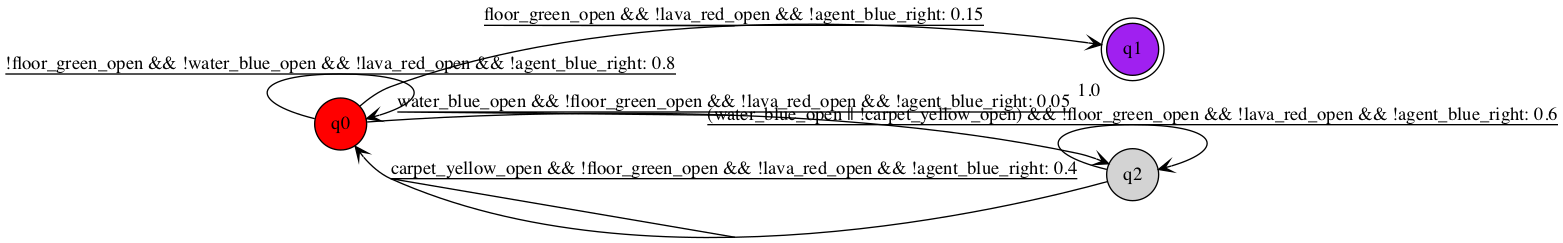

In [4]:
# PDFA
pdfa = graph_factory.get(
    'PDFA',
    graph_name="pdfa",
    config_yaml=pdfa_config_yaml,
    save_flag=save_flag,
    plot=plot_pdfa,
    view=view,
    format=format)

/Users/kandai/.pyenv/versions/anaconda3-5.3.0/envs/adam_can_play_any_strategy/lib/python3.8/site-packages/gym/wrappers/monitor.py:31: UserWarning: The Monitor wrapper is being deprecated in favor of gym.wrappers.RecordVideo and gym.wrappers.RecordEpisodeStatistics (see https://github.com/openai/gym/issues/2297)
  warnings.warn(


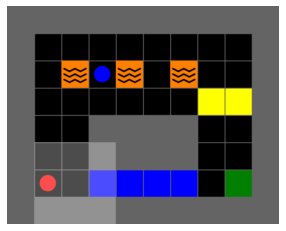

In [5]:

# OpenAI Minigrid Env
env = gym.make(env_id)
env = DynamicMinigrid2PGameWrapper(
        env,
        player_steps=player_steps,
        monitor_log_location=os.path.join(DIR, GYM_MONITOR_LOG_DIR_NAME))
env.reset()
env.render_notebook(env_filename, env_dpi)

In [6]:
file_name = env_id + 'Game'
filepath = os.path.join(DIR, 'config', file_name)
config_yaml = os.path.relpath(filepath, ROOT_PATH)

# Game Construction
start = time.time()
two_player_graph = graph_factory.get('TwoPlayerGraph',
                            graph_name='TwoPlayerGame',
                            config_yaml=config_yaml,
                            from_file=load_game_from_file,
                            minigrid=env,
                            save_flag=save_flag,
                            plot=plot_minigrid,
                            view=view,
                            format=format)
end = time.time()

In [7]:
# Product Game Construction
file_name = env_id + 'ProductAutomaton'
# config_yaml = os.path.join(DIR, 'config', file_name)
config_yaml = None

start = time.time()
game = graph_factory.get('ProductGraph',
    graph_name='ProductAutomaton',
    config_yaml=config_yaml,
    trans_sys=two_player_graph,
    automaton=pdfa,
    save_flag=True,
    prune=False,
    debug=False,
    absorbing=True,
    finite=finite,
    plot=plot_product,
    integrate_accepting=True,
    view=view,
    format=format)
end = time.time()
print(f'Product Construction took {end-start:.2f} seconds')

Product Construction took 1.06 seconds


2453 nodes and 12669 edges
1th Iteration took 2.77 seconds
2th Iteration took 4.73 seconds
3th Iteration took 5.05 seconds
4th Iteration took 4.94 seconds
Pareto Points Computation took 18.45 seconds


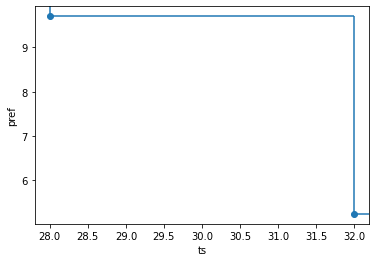

(array([[32.        ,  5.24427325],
        [28.        ,  9.70213242]]),
 {(32.0,
   5.244273254599027): <src.prism.strategy.DeterministicStrategy at 0x7f94a46660d0>,
  (28.0,
   9.702132417029237): <src.prism.strategy.DeterministicStrategy at 0x7f94a46953d0>})

In [8]:
solver = MultiObjectiveSolver(game,
                            epsilon=1e-7,
                            max_iteration=300,
                            stochastic=stochastic,
                            adversarial=adversarial)
solver.solve(plot_strategies=plot_strategies,
                plot_graph_with_strategy=plot_graph_with_strategy,
                plot_graph_with_pareto=plot_graph_with_pareto,
                plot_pareto=plot_pareto,
                speedup=speedup,
                debug=debug,
                view=view,
                format=format)

In [13]:
iterations = 100
iterations = 5

for pp in solver.get_pareto_points():
        strategy = solver.get_a_strategy_for(pp)

        print('-'*100)
        print(f"Evaluate for a pareto point {pp}")
        print('-'*100)

        sim = Simulator(env, game)
        sim.run(iterations=iterations,
                sys_strategy=strategy,
                render=False,
                record_video=iterations<=15)
        sim.get_stats()
        # sim.plot_grid()

----------------------------------------------------------------------------------------------------
Evaluate for a pareto point [32.          5.24427325]
----------------------------------------------------------------------------------------------------
Maximum Costs [32.          5.24427325]
Observation {('carpet_yellow_open', 'carpet_yellow_open', 'floor_green_open'): 5}
----------------------------------------------------------------------------------------------------
Evaluate for a pareto point [28.          9.70213242]
----------------------------------------------------------------------------------------------------
Maximum Costs [28.          9.70213242]
Observation {('water_blue_open', 'water_blue_open', 'water_blue_open', 'water_blue_open', 'carpet_yellow_open', 'carpet_yellow_open', 'floor_green_open'): 4, ('carpet_yellow_open', 'carpet_yellow_open', 'floor_green_open'): 1}


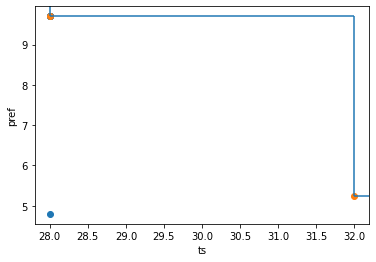

In [10]:
import matplotlib.pyplot as plt
costs = []
for result in sim._results:
    costs.append(result['Cost'])

costs = np.array(costs)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(costs[:, 0], costs[:, 1])

solver.plot_pareto_front(ax)

# Evaluation

In [11]:
# TODO: FIX THIS SHIT

player = 'sys'
SYS_ACTIONS = []
for multiactions in env.player_actions[player]:
    action_strings = []
    for agent, actions in zip(env.unwrapped.agents, multiactions):
        action_string = []
        for action in actions:
            if action is None or np.isnan(action):
                continue
            a_str = agent.ACTION_ENUM_TO_STR[action]
            action_string.append(a_str)
        action_strings.append(tuple(action_string))
    action_strs = action_strings[0] if player == 'sys' else action_strings[1:]
    SYS_ACTIONS.append(tuple(action_strs))

player = 'env'
ENV_ACTIONS = []
for multiactions in env.player_actions[player]:
    action_strings = []
    for agent, actions in zip(env.unwrapped.agents, multiactions):
        action_string = []
        for action in actions:
            if action is None or np.isnan(action):
                continue
            a_str = agent.ACTION_ENUM_TO_STR[action]
            action_string.append(a_str)
        action_strings.append(tuple(action_string))
    action_strs = action_strings[0] if player == 'sys' else action_strings[1:]
    ENV_ACTIONS.append(tuple(action_strs))

print(SYS_ACTIONS)
print(ENV_ACTIONS)

[('north', 'north'), ('north', 'south'), ('north', 'east'), ('north', 'west'), ('south', 'north'), ('south', 'south'), ('south', 'east'), ('south', 'west'), ('east', 'north'), ('east', 'south'), ('east', 'east'), ('east', 'west'), ('west', 'north'), ('west', 'south'), ('west', 'east'), ('west', 'west')]
[(('north',),), (('south',),), (('east',),), (('west',),)]


In [12]:
pp = solver.get_pareto_points()[0]
strategy = solver.get_a_strategy_for(pp)

sys_actions = [
    SYS_ACTIONS[2], 
    SYS_ACTIONS[2], 
    SYS_ACTIONS[2], 
    SYS_ACTIONS[2], 
    SYS_ACTIONS[2], 
    SYS_ACTIONS[2],
    SYS_ACTIONS[0], 
    SYS_ACTIONS[0], 
    SYS_ACTIONS[0],
    SYS_ACTIONS[2],
    SYS_ACTIONS[1],
    SYS_ACTIONS[1],
    SYS_ACTIONS[1],
    ]

env_actions = [
    ENV_ACTIONS[1], 
    ENV_ACTIONS[0], 
    ENV_ACTIONS[3], 
    ENV_ACTIONS[2], 
    ENV_ACTIONS[1], 
    ENV_ACTIONS[0],
    ]

sim = Simulator(env, game)
sim.run_turn_based_game(
    sys_actions=sys_actions,
    # env_actions=env_actions,
    render=False,
    record_video=True)
sim.get_stats()

Exception: ('north', 'east') not in [('north', 'north'), ('north', 'south'), ('south', 'south'), ('east', 'west'), ('west', 'east'), ('south', 'east'), ('east', 'south'), ('south', 'west'), ('east', 'east'), ('west', 'south'), ('west', 'west')] at (('sys', ((3, 3), 'right'), ((3, 2), 'right')), 'q0')